# Predictive alerting for cloud metrics

## Introduction

For this task, I decided to use the Air Quality dataset from the UCI Machine Learning Repository. The dataset contains time-series measurements collected from a gas multi-sensor device. More detailed information about the dataset can be found at:
https://archive.ics.uci.edu/dataset/360/air+quality
.

As the environmental setup for this task, I chose a chemical leak detection scenario. In this formulation, a leak event is defined as an extreme pollution observation (top 3% of all measurements), which is a rare but critically dangerous situation for the population. Therefore, the objective was to implement a model capable of detecting as many leak events as possible, even at the cost of generating a relatively high number of false alerts. This choice reflects the real-world setting where the cost of exposing people to highly polluted air significantly outweighs the inconvenience of false alarms.

The data underwent a basic preprocessing procedure, including restructuring the original dataset format and removing missing values. Since this is a time-series problem, a chronological split was applied: 90% of the data (approximately 328 days) was used for training, and the remaining 10% (36 days) was reserved for testing. This approach ensures realistic evaluation without temporal leakage.

To create a binary target variable aligned with the task objective, a threshold was defined as the 97th percentile of CO concentration values computed only on the training data, in order to avoid future information leakage. This threshold was then applied to the entire dataset. Observations exceeding this value were labeled as an “incident” (1), while all others were labeled as normal conditions (0).

To account for the temporal structure of the data, sliding windows were constructed using W previous observations as input and predicting whether an incident would occur within the next H time steps. The values of W and H, together with other model parameters, were selected to optimize predictive performance under the defined objective, simulating a real-world scenario where system parameters are tuned to detect incidents as effectively as possible.

After applying the windowing procedure, approximately 10% of the resulting prediction periods (6-hour intervals) contained at least one incident, reflecting the rarity of extreme events in the constructed setup.

A LightGBM classifier was selected for this task due to its strong predictive performance and computational efficiency. Four main evaluation metrics were used: Recall, ROC AUC, Precision, and F1-score. Given the strong class imbalance and the public safety framing of the problem, the primary objective was to maximize Recall for the incident class, as this directly aligns with minimizing missed dangerous events (false negatives). However, since excessive false alarms may reduce user trust in the system, Precision and overall discrimination ability (ROC AUC) were also considered to ensure balanced model performance. Probability threshold adjustment and class rebalancing techniques were applied to further support this objective.

After initial experiments, hyperparameters were optimized using Optuna-based random search, and feature selection was performed using feature importance analysis. These tuning procedures were not included in the final submission to ensure clarity and reproducibility of the reported results.

## Task Description (Provided by JetBrains)

Implement a model that predicts whether an incident will occur within the next H time steps based on the previous W steps of one or more time-series metrics. Use a sliding-window formulation and train the model using any standard machine-learning framework.

The applicant may use any suitable public dataset or generate a synthetic time series with labeled incident intervals (e.g. anomalies or threshold breaches). The emphasis is on correct problem formulation, model selection, training, and evaluation rather than dataset complexity or model size.

The solution should include a clear description of the modeling choices, the evaluation setup (including alert thresholds and metrics), and an analysis of the results. During follow-up, the applicant should be able to explain the design decisions, discuss limitations, and outline how the approach could be adapted to a real alerting system.

### Necessary imports

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
# Visualisation
import matplotlib.pyplot as plt
# Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
# Data package
from ucimlrepo import fetch_ucirepo 


### Loading the data

In [2]:
# fetch dataset 
air_quality = fetch_ucirepo(id=360) 
  
# data (as pandas dataframes) 
data = air_quality.data.features

In [3]:
data.head(10)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
5,3/10/2004,23:00:00,1.2,1197,38,4.7,750,89,1337,96,1393,949,11.2,59.2,0.7848
6,3/11/2004,0:00:00,1.2,1185,31,3.6,690,62,1462,77,1333,733,11.3,56.8,0.7603
7,3/11/2004,1:00:00,1.0,1136,31,3.3,672,62,1453,76,1333,730,10.7,60.0,0.7702
8,3/11/2004,2:00:00,0.9,1094,24,2.3,609,45,1579,60,1276,620,10.7,59.7,0.7648
9,3/11/2004,3:00:00,0.6,1010,19,1.7,561,-200,1705,-200,1235,501,10.3,60.2,0.7517


### Data preprocessing

In [4]:
# Combine date and time into a single datetime column and set it as index
data["timestamp"] = pd.to_datetime(data["Date"] + " " + data["Time"])
data.set_index("timestamp", inplace=True)
data.drop(columns=["Date", "Time"], inplace=True)

In [7]:
# After experimentation and feature important analysis, only a set of features was chosen for the final model.
cols = [ "CO(GT)", "NMHC(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)", "T", "RH", "AH"]
data = data[cols]

# Handle missing values (the dataset uses -200 to indicate missing values)
data = data.replace(-200, np.nan)

# Interpolate missing values (linear interpolation)
data = data.interpolate()

# Forward fill any remaining missing values
data = data.ffill()




Create a binary target variable to simulate "incident" occurence. For this purpose, I tok the original variable CO(GT) and converted it to a binary variable based on the historic mesurements. If the CO(GT) level is in top 3% of the historic measurements, it is converted to 1, reflecting an incident of high pollution.

In [8]:
# Train test split (chronological)
split = int(len(data) * 0.9)

train_data = data.iloc[:split]
test_data = data.iloc[split:]

In [9]:
# Calculate the incident threshold (only on training data to avoid data leakage)
threshold = np.quantile(train_data["CO(GT)"], 0.97)

# Apply the threshold to the dataset to create the binary target variable (1 for incident, 0 for no incident)
incident = (data["CO(GT)"] > threshold).astype(int)

In [10]:
incident.value_counts()

CO(GT)
0    9079
1     278
Name: count, dtype: int64

Sliding window

In [11]:
# remove target from features
feature_data = data.drop(columns = ["CO(GT)"])

# Create sequences for time series classification
X, y = [],[]

W = 48  # Window size (past 2 days)
H = 6  # Horizon size (next 6 hours)

# Start from W to ensure enough past data for the first window, and end at len(data) - H to ensure enough future data for the horizon
for t in range(W, len(data) - H):
    # Create an array of shape (W * num_features,) for the window and a binary label for the horizon
    window = feature_data.iloc[t-W:t].values.flatten()
    horizon = incident.iloc[t:t+H].values

    # Append the window and label to the respective lists
    X.append(window)
    y.append(int(horizon.any()))  # Label is 1 if any incident occurs in the horizon, else 0

# Convert lists to numpy arrays for model training
X = np.array(X)
y = np.array(y)
    

In [12]:
print(f"X shape: {X.shape}")
print(f"Percentage of incidents: {np.mean(y) * 100:.2f}%")

X shape: (9303, 336)
Percentage of incidents: 9.96%


Final data splitting

In [13]:
# Split the dataset into training and testing sets
window_split = split - W # Adjust split point to account for the initial window size
X_train = np.array(X[:window_split])
y_train = np.array(y[:window_split])
X_test = np.array(X[window_split:])
y_test = np.array(y[window_split:])

### Initialising and training the model

In [14]:
# LightGBM model with hyperparameters from Optuna optimization
model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate= 0.049319434849963414,
    num_leaves=2701,
    max_depth= 6,
    feature_fraction = 0.44340421708692124,
    bagging_fraction = 0.9509321079656763,
    min_child_samples=667,
    bagging_freq = 2,
    lambda_l1 = 4.037716064044794,
    lambda_l2 = 3.3103307012424983,
    min_data_in_leaf = 667,
    max_bin= 181,
    class_weight = {0:1, 1:3} # More weight to the minority class (incidents)
)

# Train the model with early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)], # Use the test set for early stopping evaluation
    eval_metric="auc",
    callbacks=[lgb.early_stopping(50)]
    )


[LightGBM] [Warning] min_data_in_leaf is set=667, min_child_samples=667 will be ignored. Current value: min_data_in_leaf=667
[LightGBM] [Warning] feature_fraction is set=0.44340421708692124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44340421708692124
[LightGBM] [Warning] lambda_l1 is set=4.037716064044794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.037716064044794
[LightGBM] [Warning] lambda_l2 is set=3.3103307012424983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3103307012424983
[LightGBM] [Warning] bagging_fraction is set=0.9509321079656763, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9509321079656763
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=667, min_child_samples=667 will be ignored. Current value: min_data_in_leaf=667
[LightGBM] [Warning] feature_fraction is set=0.44340421708692124, colsampl

,boosting_type,'gbdt'
,num_leaves,2701
,max_depth,6
,learning_rate,0.049319434849963414
,n_estimators,1000
,subsample_for_bin,200000
,objective,None
,class_weight,"{0: 1, 1: 3}"
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,667


### Results (evaluation)

In [15]:
# Predict probabilities and apply a threshold to get binary predictions
y_proba = model.predict_proba(X_test)[:, 1]  # probability of class 1

best_thr = 0.2 # Threshold was tuned based on the desired balance between precision and recall.

y_pred = (y_proba >= best_thr).astype(int)
# Evaluate the model
print("-----------------------------")
print("-- Model Evaluation --")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("                             ")
print("Classification report:")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

[LightGBM] [Warning] min_data_in_leaf is set=667, min_child_samples=667 will be ignored. Current value: min_data_in_leaf=667
[LightGBM] [Warning] feature_fraction is set=0.44340421708692124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44340421708692124
[LightGBM] [Warning] lambda_l1 is set=4.037716064044794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.037716064044794
[LightGBM] [Warning] lambda_l2 is set=3.3103307012424983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3103307012424983
[LightGBM] [Warning] bagging_fraction is set=0.9509321079656763, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9509321079656763
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
-----------------------------
-- Model Evaluation --
Confusion Matrix:
[[618 202]
 [ 17  93]]
                             
Classification report:
              precision    recall  f1-score   suppor

c:\Users\pavel\miniconda3\envs\test\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


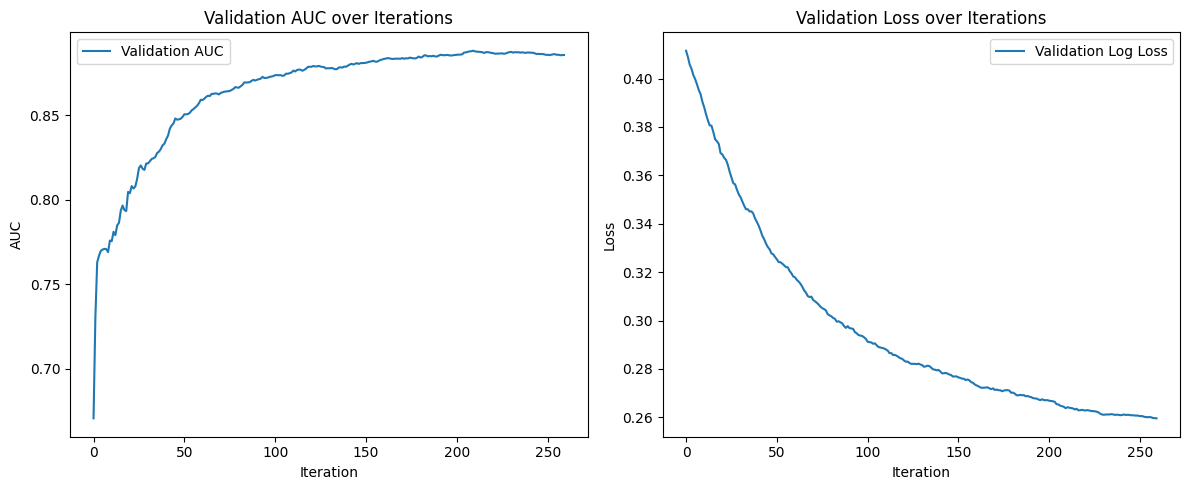

In [16]:
# Plot validation AUC and loss curves
eval_results = model.evals_result_
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(eval_results["valid_0"]["auc"], label="Validation AUC")
plt.title("Validation AUC over Iterations")
plt.xlabel("Iteration")
plt.ylabel("AUC")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(eval_results["valid_0"]["binary_logloss"], label="Validation Log Loss")
plt.title("Validation Loss over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# Tune threshold for best F1 score (was used during development to find the optimal threshold, but final 
# threshold gives more weight to recall to catch more incidents, even at the cost of more false positives)
best_f1 = 0
best_thr = 0
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for thr in thresholds:
    y_thr = (y_proba >= thr).astype(int)
    f1 = f1_score(y_test, y_thr)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr

print("Best threshold:", best_thr)


Best threshold: 0.4


## Results analysis & discussion

Overall, the model achieved strong performance in terms of both incident detection and overall discrimination ability. Specifically, 85% of all incident periods were correctly identified, while the ROC AUC score of 0.88 indicates a high capacity of the model to separate normal and extreme pollution events. These results suggest that the model successfully captures relevant temporal patterns associated with extreme CO concentration levels.

From a real-world perspective, however, the system is not yet fully deployment-ready. Although maximizing recall was the primary objective, missing 15% of critical incidents may still represent an unacceptable risk in high-stakes environmental settings. At the same time, the precision score of 0.32 indicates a substantial number of false alarms. While this trade-off was intentionally accepted to prioritize safety, excessive false alerts could negatively impact public trust in the system and reduce compliance with warnings over time.

Several limitations should be considered. First, although LightGBM demonstrated strong predictive performance and serves as a solid benchmark model, more advanced approaches could potentially improve results. For example, ensemble or stacked architectures, where separate models specialize in different aspects of the classification task and are combined via probability weighting, may yield better calibration and class balance. Additionally, deep learning models designed specifically for sequential data, such as LSTM or other recurrent neural networks, could capture longer-term temporal dependencies more effectively.

Second, the predictive capacity of the dataset itself may be limited. The available sensor measurements may not fully explain extreme pollution dynamics, and additional contextual variables (e.g., meteorological conditions or external emission sources) could enhance model performance. More sophisticated feature engineering, such as rolling statistics, trend indicators, or lag-based features, may also strengthen the signal extracted from historical observations.

Finally, the threshold used to define incidents was constructed for simulation purposes (top 3% of CO values in the training data) and does not necessarily correspond to real regulatory or health-based standards. In real-world applications, the threshold would likely be determined by environmental authorities and may significantly alter the class distribution and model performance characteristics.

In conclusion, although the current system is not yet suitable for immediate real-life deployment, this study demonstrates that future pollution incidents within the next H hours can be predicted with substantial accuracy using W previous observations. The model provides a strong methodological benchmark and a solid foundation for future experimentation and refinement in environmental risk forecasting.